# Ladybug Classification and Dot Counting Project

This project involves analyzing images of ladybugs to classify them into different categories based on their visual features. 

European and Asian ladybugs have distinct visual differences. European ladybugs typically have a larger number of black spots on a red background, usually around 7 and often with some spots merging together. In contrast, Asian ladybugs tend to have fewer and more defined spots, often with distinct black M-shaped markings on a red or orange background. It's important to note that Asian ladybugs may display more variability in spot patterns and colors compared to the European Ones.

We were given a dataset of 100 ladybugs images and vectors and we had to find a way to sort and predict their type (European or Asian.)
Initially, the images undergo preprocessing steps such as background removal using image segmentation techniques. Once the backgrounds are removed and the image is filtered, we count the numbers of spots on the shell and use decision trees to predict which kind of ladybug we are facing.

The images go through resized and are subjected to the K-means clustering algorithm to group them based on similarity in pixel values. Each cluster representing a distinct visual pattern observed across the ladybug images. 


The project utilizes libraries like OpenCV for image processing, scikit-learn for machine learning tasks such as clustering with K-means, and matplotlib for visualizing the results. By categorizing ladybugs into clusters, the project aims to provide insights into the diversity of ladybug appearances in the dataset.

#### Made by Steven BRADLEY & Thomas FERRANDIS

### Imports

In [209]:
! pip install opencv-python
! pip install Pillow

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import csv
import pandas as pd

import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

### Definition of functions

In [210]:
def add_zeros(number):
    """
    Adds zeros to a number so that it has at least three digits.

    Parameters:
    number (int): The number to format.

    Returns:
    str: The formatted number as a string with at least three digits.
    """
        
    # Convert the number to a string
    number_str = str(number)

    # Check the length of the string
    if len(number_str) >= 3:
        # If the number has three or more digits, return it as is
        return number_str
    else:
        # If the number has less than three digits, add leading zeros
        return number_str.zfill(3)

In [211]:
def mask_range(pixel,tolerance,image):
    """
    Create a binary mask for a specific pixel value and tolerance range.

    Args:
        pixel: The pixel value to create the mask for.
        tolerance: The range of acceptable values around the pixel value.

    Returns:
        binary_mask: Binary mask representing pixels within the tolerance range.

    Note:
        This function assumes that the 'thresholded_image_or' variable is available.

    """
    
    # Create lower and upper bounds arrays
    lower_bound = pixel - tolerance
    upper_bound = pixel + tolerance

    # Create a binary mask based on the grayscale image and RGB comparison
    binary_mask = cv2.inRange(image, lower_bound, upper_bound)
    return binary_mask

In [212]:
def ouverture(nom):
    """
    Opens an image file, converts its color format, and displays it.

    Parameters:
    nom (str): The name of the image file to open.

    Returns:
    None
    """
    # Open and save image in a new format
    image = cv2.cvtColor(cv2.imread(nom), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

In [213]:
def ouverture_et_nvformat_seg(nom_image,nom_gris):
    """
    Opens an image, converts it to grayscale, displays it, and saves it in a new format.

    Parameters:
    nom_image (str): The name of the image file to open.
    nom_gris (str): The name of the file to save the grayscale image.

    Returns:
    None
    """
    # Open the image and convert it to grayscale
    image_t = Image.open(nom_image).convert("L")

    # Display the grayscale image
    plt.imshow(image_t, cmap='Greys')
    plt.axis('off')
    
    # Save the grayscale image in the new format
    plt.savefig(nom_gris, bbox_inches='tight', pad_inches=0)

In [214]:
def ouverture_et_nvformat_seg2(nom_image,nom_gris):
    """
    Opens an image, converts it to grayscale, and saves it in a new format.

    Parameters:
    nom_image (str): The name of the image file to open.
    nom_gris (str): The name of the file to save the grayscale image.

    Returns:
    None
    """
    
    # Convert the image to grayscale
    image_t = Image.open(nom_image).convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(image_t)

    # Create a new grayscale image using the 'L' mode
    image_greyscale = Image.fromarray(image_array, mode='L')

    # Save the image with the 'Greys' colormap
    image_greyscale.save(nom_gris)

In [215]:
def remove_background(image):
    """
    Removes the background of an image by masking out pixels that match the RGB values of the first pixel.

    Parameters:
    image (numpy.ndarray): The image from which to remove the background.

    Returns:
    numpy.ndarray: The image with the background removed.
    """
        
    # Get the RGB values of the first pixel
    target = np.copy(image[0][0]).item()

    # Create a binary mask for the target RGB values
    binary_mask = mask_range(target,1,thresholded_image_or)

    # Invert the binary mask to allow everything except the pixel to be masked out
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Apply the mask to the original grayscale image to extract the pixels
    result = cv2.bitwise_and(image, image, mask=inverted_mask)

    return result

In [216]:
def carapace_pixel_masque(image):
    """
    Creates a mask for the most common non-background pixel value in an image and applies it.

    Parameters:
    image (numpy.ndarray): The grayscale image to process.

    Returns:
    numpy.ndarray: The binary mask image with the background removed.
    """
    
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 1)

    # Get the unique pixel values and their counts
    unique_pixels, counts = np.unique(pixels, return_counts=True)

    # Sort the pixel counts in descending order
    sorted_indices = np.argsort(counts)[::-1]

    # Get the two most common pixel values
    most_common_pixels = unique_pixels[sorted_indices[:2]]

    background_color = np.array([0])

    most_common_pixels_not_background = (
        most_common_pixels[1] if most_common_pixels[0]==0 else most_common_pixels[0]
    )    

    background_px = most_common_pixels_not_background.item()
    caparace_mask = mask_range(background_px,0,image)

    # Apply the mask to the original grayscale image to extract the pixels
    result = cv2.bitwise_and(image, image, mask=caparace_mask)

    _, thresh_image_mask = cv2.threshold(result, background_px-1, 255, cv2.THRESH_BINARY)
    
    return thresh_image_mask
    

In [217]:
def find_avgcolor(image,mask):
    """
    Finds the closest predefined color to the average color of the masked region in the image.

    Parameters:
    image (numpy.ndarray): The image from which to find the average color.
    mask (numpy.ndarray): The mask indicating the region of interest in the image.

    Returns:
    str: The name of the closest predefined color.
    """
    
    # Définir les valeurs RVB des couleurs prédéfinies
    colors = {
        'Rouge': [(255, 0, 0), (220, 20, 60), (178, 34, 34), (205, 92, 92), (255, 99, 71), (255, 165, 0), (255, 140, 0), (255, 127, 80), (255, 69, 0), (255, 128, 0)],
        'Noir': [(0, 0, 0)],
        'Jaune': [(255, 255, 0), (255, 215, 0), (255, 218, 185), (255, 250, 205), (240, 230, 140)]
    }

    # Obtenir les pixels de la carapace à partir de l'image masquée
    carapace_pixels = image[mask != 0]

    # Calculer la couleur moyenne de la carapace
    mean_color = np.mean(carapace_pixels, axis=0)
    mean_color = mean_color.astype(int)

    # Inverser l'ordre des composantes RVB
    mean_color = mean_color[::-1]

    # Afficher les valeurs RVB de la couleur moyenne
    #print("Couleur moyenne de la carapace (RVB) :", mean_color)

    # Calculer la distance euclidienne entre la couleur moyenne et chaque couleur prédéfinie en utilisant l'espace RGB
    distances = {color: min(np.linalg.norm(mean_color - rgb) for rgb in color_values) for color, color_values in colors.items()}

    # Trouver la couleur la plus proche
    closest_color = min(distances, key=distances.get)

    # Afficher les distances entre la couleur moyenne et chaque couleur prédéfinie
    #print("Distances :", distances)

    # Convertir la couleur moyenne en représentation hexadécimale (RVB)
    mean_color_hex = '#{:02x}{:02x}{:02x}'.format(mean_color[0], mean_color[1], mean_color[2])
    #print("Couleur moyenne de la carapace (hex) :", mean_color_hex)

    #print("Couleur la plus proche :", closest_color)
    
    return closest_color


In [218]:
def invert_mask(mask,image_nobackground):
    """
    Inverts a binary mask to mask out everything except the specified region in the image.

    Parameters:
    mask (numpy.ndarray): The binary mask indicating the region to keep.
    image_nobackground (numpy.ndarray): The image from which to remove the background.

    Returns:
    numpy.ndarray: The inverted binary mask.
    """
    
    # Invert the binary mask to allow everything except the pixel to be masked out
    inverted_caparace_mask = cv2.bitwise_not(mask)
    not_result = cv2.bitwise_and(image_nobackground, image_nobackground, mask=inverted_caparace_mask)
    _, inverted_mask = cv2.threshold(not_result, 0, 255, cv2.THRESH_BINARY)
    return inverted_mask

In [219]:
def showcontour(contours,text):
    """
    Displays contours on a blank image and shows it using OpenCV.

    Parameters:
    contours (list): List of contours to display.
    text (str): Text to display as the window name.

    Returns:
    None
    """
        
    blobs_image = np.zeros_like(image)
    
    for contour in contours:
        cv2.drawContours(blobs_image, [contour], 0, (255), -1)
        
    cv2.imshow(text, blobs_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [220]:
def erode(image,show = True):
    """
    Applies erosion to an image, finds contours, filters contours based on circularity, and displays results.

    Parameters:
    image (numpy.ndarray): The input image.
    show (bool): Flag to indicate whether to display images and contours (default is True).

    Returns:
    list: List of contours filtered based on circularity.
    int: Number of filtered contours.
    """
        
    nb_points = 0
    
    kernel = np.ones((3, 3), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)

    # Find contours on the edges
    contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert contours tuple to a list
    contours_list = list(contours)

    # Find the contour with the maximum area
    max_contour = max(contours_list, key=cv2.contourArea)

    # Create a new list without the contour with the maximum area
    contours_list = [contour for contour in contours_list if not np.array_equal(contour, max_contour)]
    
    if(show):
        for x in contours:
            print('area :',cv2.contourArea(x))
            print('circularity',((4 * np.pi * cv2.contourArea(x)) / (cv2.arcLength(x, True) ** 2)))



    # Filter contours based on circularity
    circularity = 0.3
    circularity_contours = [contour for contour in contours if cv2.contourArea(contour) > 0 and ((4 * np.pi * cv2.contourArea(contour)) / (cv2.arcLength(contour, True) ** 2)) > circularity]
    
    mask = np.zeros_like(image)

    # Draw the filtered contours on the mask
    cv2.drawContours(mask, circularity_contours, -1, 255, thickness=cv2.FILLED)
    
    # Apply the mask to the original image
    contours_im = cv2.bitwise_and(image, image, mask=mask)
    
    nb_points = len(circularity_contours)
    
    if(show):
        #for x in circularity_contours:
            #print('area :',cv2.contourArea(x))
            #print('circularity',((4 * np.pi * cv2.contourArea(x)) / (cv2.arcLength(x, True) ** 2)))
        
        
        cv2.imshow('Not eroded', image)
        cv2.imshow('Eroded', eroded_image)

        cv2.imshow('Eroded + Contours', contours_im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return circularity_contours,nb_points

In [221]:
#PARAMETRES

# Load the Excel file
workbook = openpyxl.load_workbook('BDD-TEST.xlsx')
sheet = workbook['Feuille 1']

num_ = 8
num = add_zeros(num_)

grey_name = 'image_gris_4.png'
seg_name = 'training/im-'+num+'_seg.png'
#seg_name = 'segmentation_mask.png'

image_name = 'training/im-'+num+'_im.png'
#image_name = 'ladybug_image.png'

# Counting the number of dots on the ladybug's shell

### Image Segmentation and Feature Extraction for Shell Analysis

C:\Users\steve_ao846tt\AppData\Local\Temp\ipykernel_8212\4201868956.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


   Image_id Couleurs Points
0    im-001    Rouge      6
1    im-002    Rouge      7
2    im-003    Rouge     16
3    im-004    Rouge     14
4    im-005    Rouge     17
5    im-006    Rouge     10
6    im-007    Rouge      4
7    im-008     Noir      4
8    im-009    Rouge     11
9    im-010    Rouge     16
10   im-011    Rouge      7
11   im-012    Rouge      7
12   im-013    Rouge     16
13   im-014    Rouge      6


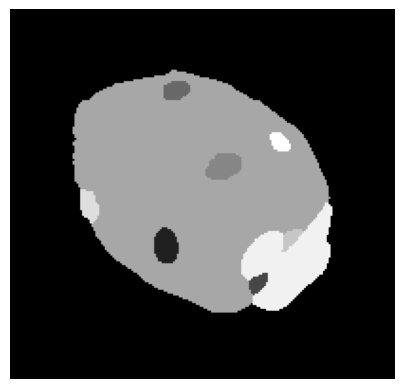

In [222]:
df = pd.DataFrame(columns=['Image_id','Couleurs','Points'])

backgroundless_images = []

for x in range(1,15):
    # print(x)
    seg_name = 'test/im-'+add_zeros(x)+'_seg.png'
    image_name = 'test/im-'+add_zeros(x)+'_im.png'
    grey_name = 'grey_image_temp.png'


    # Convert segmentation image to grayscale
    ouverture_et_nvformat_seg(seg_name,grey_name)
    thresholded_image_or = cv2.imread(grey_name, cv2.IMREAD_GRAYSCALE)

    # Find black pixels (pixels with intensity 0)
    black_pixels = np.where(thresholded_image_or == 0)

    # Replace black pixels with grey
    thresholded_image_or[black_pixels] = 127

    # Remove background from the image
    backgroundless = remove_background(thresholded_image_or)

    # Create a mask for the shell
    mask_carapace = carapace_pixel_masque(backgroundless)

    # Read and resize the original image
    image = cv2.imread(image_name)
    image = cv2.resize(image, (mask_carapace.shape[1], mask_carapace.shape[0]))

    # Apply background mask if assetBackgroundless = True
    assetBackgroundless = True
    if assetBackgroundless:
        _, tresh_backgroundless = cv2.threshold(backgroundless, 1, 255, cv2.THRESH_BINARY)
        backgroundless_masked_image = cv2.bitwise_and(image, image, mask=tresh_backgroundless)
        backgroundless_images.append(backgroundless_masked_image)

    # Apply shell mask
    masked_image = cv2.bitwise_and(image, image, mask=mask_carapace)

    # Invert the mask
    invertmask = invert_mask(mask_carapace,backgroundless)

    # Optional debug visualizations
    show = False
    if show:
        cv2.imshow('1 - thresholded_image_or', thresholded_image_or) 
        cv2.imshow('BACKGROUNDLESS', backgroundless)    
        cv2.imshow('MASQUE AVANT INVERT', mask_carapace)
        cv2.imshow('MASQUE INVERT ', invertmask)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Erode the inverted mask and find contours
    contours,pts = erode(invertmask,False)

    

    # Create a new row to append
    new_row = pd.DataFrame({'Image_id' : ['im-'+add_zeros(x)] ,'Points': [pts],'Couleurs': [find_avgcolor(masked_image,mask_carapace)]})
    # Append the new row to the data frame
    df = df.append(new_row, ignore_index=True)
    
print(df)

### Adding Data to the BDD TEST Excel file

In [223]:
# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Image_id is stored as a list, so get the actual value
    image_id = row['Image_id'][0]
    couleurs = row['Couleurs']
    points = row['Points']
    
    # Write Couleurs to column H and Points to column I (assuming starting from row 2)
    sheet[f'H{index + 2}'] = couleurs
    sheet[f'I{index + 2}'] = points

# Save the workbook
workbook.save('BDD-TEST.xlsx')

print("Data written to Excel file successfully.")

Data written to Excel file successfully.


### Classification of Shell Features using Decision Tree

In [224]:
# Load the data from the CSV file
data = pd.read_excel('BDD-TEST.xlsx')

print(data)

# Separate the features (X) and the target variables (y)
X = data[['Points', 'Couleurs']]
y = data['Race Officielle']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the columns to be encoded using one-hot encoding
columns_to_encode = ['Couleurs']

# Create the ColumnTransformer object for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), columns_to_encode)],
    remainder='passthrough'
)

# Apply preprocessing on the training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Apply preprocessing on the validation data
X_val_encoded = preprocessor.transform(X)

# Apply preprocessing on the test data
X_test_encoded = preprocessor.transform(X_test)

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Train the decision tree on the training data
clf.fit(X_train_encoded, y_train)

# Predict the classes for the test data
y_pred = clf.predict(X_test_encoded)

# Display the classification report
print(classification_report(y_test, y_pred))

# Evaluate the model's performance
accuracy = clf.score(X_test_encoded, y_test)
print("Accuracy:", accuracy)


     N° Photo  Nb de Points Visible Nb de Points Hypothese Couleur  \
0           1                     7                      7   Rouge   
1           2                     7                      7  Orange   
2           3                    16                     17   Rouge   
3           4                    19                     19  Orange   
4           5                    18                     19   Rouge   
..        ...                   ...                    ...     ...   
195       196                     7                      7   Rouge   
196       197                     3                      4    Noir   
197       198                     4                      7   Rouge   
198       199                     4                      4    Noir   
199       200                     6                      7   Rouge   

    Race Hypothétique Race Officielle Commentaires Couleurs  Points  \
0                   E               E          NaN    Rouge       6   
1                

### Prediction Analysis and Ladybug Classification Results

In [225]:
# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame({'Prediction': y_pred})

# Count the number of European and Asian ladybugs
count = predictions_df['Prediction'].value_counts()


# Display the number of European and Asian ladybugs
print('Number of European ladybugs:', count[0])
print('Number of Asian ladybugs:', count[1])

Number of European ladybugs: 32
Number of Asian ladybugs: 28


### Binary Conversion of Predictions and Result Display

In [226]:
y_pred = np.where(y_pred == 'E', 0, y_pred)
y_pred = np.where(y_pred == 'A', 1, y_pred)
data = pd.DataFrame({'y_pred': y_pred})

### Predicting and Saving New Ladybug Data with Preprocessing and Model Application

In [227]:
# The test data (X_new)
X_new = df[['Points', 'Couleurs']]

print(X_new)

# Apply the same preprocessing transformations as for the training data
X_new_encoded = preprocessor.transform(X_new)

# Use the trained model to make predictions on the new ladybug data
y_pred_new = clf.predict(X_new_encoded)

# Print the predictions for the new ladybugs
data_new = pd.DataFrame({'y_pred_new': y_pred_new})


points_column = df[['Image_id', 'Points']]
combined_df = pd.concat([points_column, data_new], axis=1)


y_pred_new = np.where(y_pred_new == 'E', 0, y_pred_new)
y_pred_new = np.where(y_pred_new == 'A', 1, y_pred_new)

print(y_pred_new)


combined_df.to_csv("test_label.csv", index=False)

   Points Couleurs
0       6    Rouge
1       7    Rouge
2      16    Rouge
3      14    Rouge
4      17    Rouge
5      10    Rouge
6       4    Rouge
7       4     Noir
8      11    Rouge
9      16    Rouge
10      7    Rouge
11      7    Rouge
12     16    Rouge
13      6    Rouge
[0 0 1 1 1 1 0 1 1 1 0 0 1 0]


Now you can check the predictions in the new file test_label.csv in the column 'y_pred_new'.

# Clustering

### Visualization of Processed Images without Background

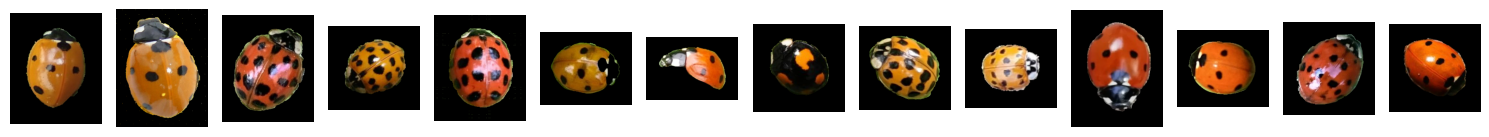

In [228]:
# Check if there are any images in the list
if len(backgroundless_images) == 0:
    print("Aucune image trouvée dans le dossier.")
else:
    # Display the images
    fig, axes = plt.subplots(nrows=1, ncols=len(backgroundless_images), figsize=(15, 5))

    for i, image in enumerate(backgroundless_images):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


### Clustering and Visualization of Backgroundless Images using K-means

C:\Users\steve_ao846tt\AppData\Local\Temp\ipykernel_8212\2879952206.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_np = np.array(backgroundless_images)


14


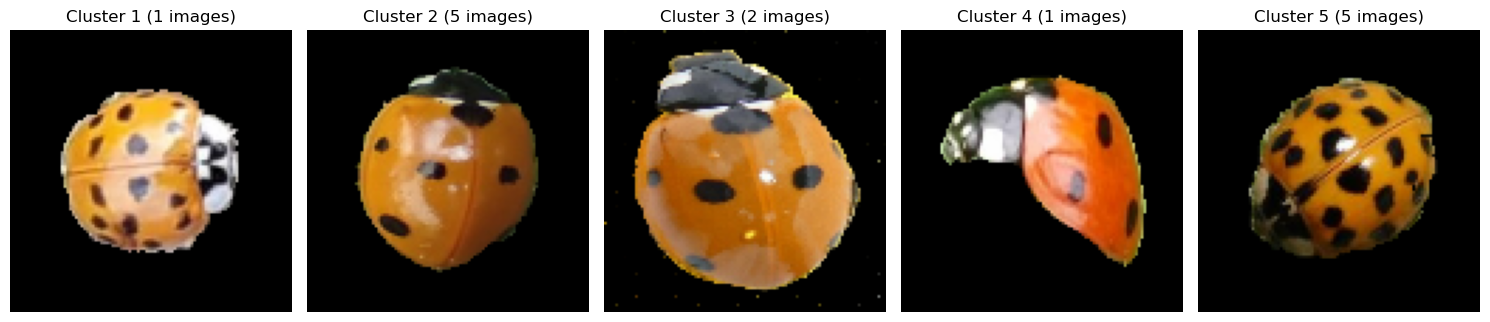

In [229]:
import glob
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Check if there are any images in the list
if len(backgroundless_images) == 0:
    print("Aucune image trouvée dans le dossier.")
else:
    # Convert the images to numpy arrays
    images_np = np.array(backgroundless_images)

    # Resize the images to a fixed size
    desired_size = (100, 100)
    resized_images = []
    for image in images_np:
        resized_image = cv2.resize(image, desired_size)
        resized_images.append(resized_image)
    resized_images_np = np.array(resized_images)
    
    print(len(resized_images_np))

    # Apply the K-means algorithm to the resized images
    n_samples, h, w, _ = resized_images_np.shape
    images_2d = resized_images_np.reshape((n_samples, h * w * 3))

    # Normalize the pixel values between 0 and 1
    images_2d = images_2d.astype(float) / 255

    # Apply the K-means clustering algorithm
    n_clusters = 5  # Nombre de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(images_2d)

    # Display the images with their assigned cluster
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(15, 5))

    for cluster in range(n_clusters):
        cluster_images = resized_images_np[labels == cluster]
        cluster_size = len(cluster_images)
        axes[cluster].imshow(cv2.cvtColor(cluster_images[0], cv2.COLOR_BGR2RGB))
        axes[cluster].set_title(f"Cluster {cluster+1} ({cluster_size} images)")
        axes[cluster].axis('off')

    plt.tight_layout()
    plt.show()


5 clusters have been created. Now we will show one in more details : 

### Visualization of Images in a Specific Cluster

Showing  1  image(s) :


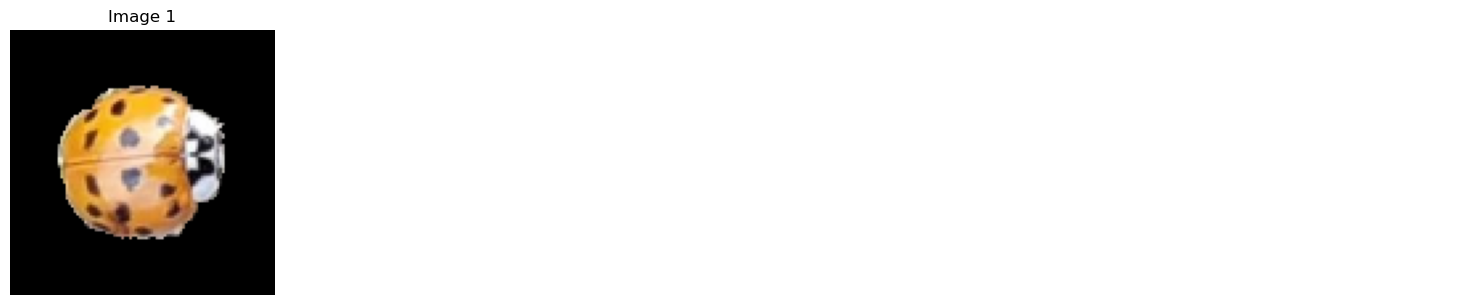

In [234]:
# Determine the cluster number to observe (from 1 to n_clusters)
cluster_to_observe = 1

# Retrieve the images from the selected cluster
selected_cluster_images = resized_images_np[labels == cluster_to_observe - 1]
num_images = len(selected_cluster_images)

print("Showing ",num_images," image(s) :")

# Define the grid size for subplots
num_cols = 5
num_rows = max(1, (num_images + num_cols - 1) // num_cols)  # Ensure at least 1 row

# Create the grid of subplots to display the images
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

# Flatten axes if there's only one row or column
if num_rows == 1:
    axes = axes[np.newaxis, :]

if num_cols == 1:
    axes = axes[:, np.newaxis]

# Iterate through the images and display them in the subplots
for i, image in enumerate(selected_cluster_images):
    ax = axes[i // num_cols, i % num_cols]  # This indexing now works for both 1D and 2D cases
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

# Remove unused subplots
for j in range(num_images, num_rows * num_cols):
    axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()
